# Laboratorium 4 - Sieć neuronowa w PyTorch
## Jakub Czajkowski 272709

In [103]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

seed = 10
np.random.seed(seed)
torch.manual_seed(seed)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0
CUDA available: False


## 1. Przygotowanie danych

Wczytujemy dane heart disease i przygotowujemy je analogicznie jak w poprzednich laboratoriach.

In [104]:
# Wczytanie danych
with open('data.pkl', 'rb') as f:
    X_matrix, y = pickle.load(f)

# Przygotowanie etykiet
y = y['num'].apply(lambda v: 1 if v > 0 else 0)


# Podział na train/test
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_matrix, y, test_size=0.2, stratify=y, random_state=seed
)

# Konwersja do numpy
X_train_raw = np.asarray(X_train_raw, dtype=np.float32)
X_test_raw = np.asarray(X_test_raw, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32).reshape(-1, 1)
y_test = np.asarray(y_test, dtype=np.float32).reshape(-1, 1)

# Normalizacja danych
train_mean = X_train_raw.mean(axis=0)
train_std = X_train_raw.std(axis=0, ddof=0)
train_std[train_std == 0] = 1.0

X_train = (X_train_raw - train_mean) / train_std
X_test = (X_test_raw - train_mean) / train_std

print(f"Dataset shape: {X_train.shape}")
print(f"Number of features: {X_train.shape[1]}")
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"Class distribution - Train: {y_train.mean():.3f}, Test: {y_test.mean():.3f}")

Dataset shape: (242, 25)
Number of features: 25
Train samples: 242, Test samples: 61
Class distribution - Train: 0.459, Test: 0.459


In [105]:
# Konwersja do tensorów PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(f"X_train shape: {X_train_tensor.shape}")
print(f"y_train shape: {y_train_tensor.shape}")
print(f"Data type: {X_train_tensor.dtype}")

X_train shape: torch.Size([242, 25])
y_train shape: torch.Size([242, 1])
Data type: torch.float32


## 2. Definicja architektury sieci w PyTorch

Tworzymy sieć neuronową analogiczną do tej z poprzednich laboratoriów:
- Warstwa wejściowa: liczba cech (13)
- Warstwa ukryta: 128 neuronów z aktywacją ReLU
- Warstwa wyjściowa: 1 neuron z aktywacją Sigmoid (klasyfikacja binarna)

In [106]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=1):
        super(NeuralNetwork, self).__init__()
        
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Forward pass
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

## 3. Funkcje pomocnicze do trenowania i ewaluacji

In [107]:
def train_model(model, train_loader, criterion, optimizer, epochs=1000, verbose=False):
    model.train()
    loss_history = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Średnia strata na epokę
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        
        if verbose and (epoch + 1) % max(1, epochs // 10) == 0:
            print(f"Epoch {epoch+1:4d}/{epochs} | Loss: {avg_loss:.6f}")
    
    return loss_history

In [108]:
def evaluate_model(model, X, y, threshold=0.5):
    model.eval()
    
    with torch.no_grad():
        # Predykcje
        y_prob = model(X).numpy()
        y_pred = (y_prob >= threshold).astype(np.float32)
        
        # Konwersja do numpy
        y_true = y.numpy()
        
        # Obliczenie metryk
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        auc_roc = roc_auc_score(y_true, y_prob)
        
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_roc
    }

## 4. Eksperyment 1: Porównanie optimizerów

Porównamy działanie trzech optimizerów:
- **SGD** (Stochastic Gradient Descent)
- **Adam** (Adaptive Moment Estimation)
- **RMSprop** (Root Mean Square Propagation)

In [109]:
# Parametry wspólne dla wszystkich optimizerów
batch_size = 32
learning_rate = 0.01
epochs = 1000
hidden_size = 128

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Funkcja kosztu
criterion = nn.BCELoss()

# Lista optimizerów do testowania
optimizers_config = {
    'SGD': lambda params: optim.SGD(params, lr=learning_rate, momentum=0.9),
    'Adam': lambda params: optim.Adam(params, lr=learning_rate),
    'RMSprop': lambda params: optim.RMSprop(params, lr=learning_rate)
}

# Słownik na wyniki
optimizer_results = {}
optimizer_losses = {}

print("=" * 70)
print("EKSPERYMENT 1: Porównanie optimizerów")
print("=" * 70)
print(f"Batch size: {batch_size}, Learning rate: {learning_rate}, Epochs: {epochs}\n")

for optimizer_name, optimizer_fn in optimizers_config.items():
    print(f"\nTrenowanie z optimizerem: {optimizer_name}")
    print("-" * 70)
    
    # Nowy model dla każdego optimizera
    model = NeuralNetwork(input_size, hidden_size)
    optimizer = optimizer_fn(model.parameters())
    
    # Trenowanie
    loss_history = train_model(model, train_loader, criterion, optimizer, epochs=epochs, verbose=True)
    optimizer_losses[optimizer_name] = loss_history
    
    # Ewaluacja
    train_metrics = evaluate_model(model, X_train_tensor, y_train_tensor)
    test_metrics = evaluate_model(model, X_test_tensor, y_test_tensor)
    
    optimizer_results[optimizer_name] = {
        'train': train_metrics,
        'test': test_metrics,
        'model': model
    }
    
    print(f"\nWyniki dla {optimizer_name}:")
    print(f"  Train - Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['f1_score']:.4f}, AUC: {train_metrics['auc_roc']:.4f}")
    print(f"  Test  - Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1_score']:.4f}, AUC: {test_metrics['auc_roc']:.4f}")

EKSPERYMENT 1: Porównanie optimizerów
Batch size: 32, Learning rate: 0.01, Epochs: 1000


Trenowanie z optimizerem: SGD
----------------------------------------------------------------------
Epoch  100/1000 | Loss: 0.081761
Epoch  200/1000 | Loss: 0.027279
Epoch  300/1000 | Loss: 0.014526
Epoch  400/1000 | Loss: 0.009487
Epoch  500/1000 | Loss: 0.006492
Epoch  600/1000 | Loss: 0.005151
Epoch  700/1000 | Loss: 0.003708
Epoch  800/1000 | Loss: 0.003012
Epoch  900/1000 | Loss: 0.002731
Epoch 1000/1000 | Loss: 0.002254

Wyniki dla SGD:
  Train - Acc: 1.0000, F1: 1.0000, AUC: 1.0000
  Test  - Acc: 0.8197, F1: 0.7925, AUC: 0.9004

Trenowanie z optimizerem: Adam
----------------------------------------------------------------------
Epoch  100/1000 | Loss: 0.000747
Epoch  200/1000 | Loss: 0.000175
Epoch  300/1000 | Loss: 0.000070
Epoch  400/1000 | Loss: 0.000035
Epoch  500/1000 | Loss: 0.000019
Epoch  600/1000 | Loss: 0.000012
Epoch  700/1000 | Loss: 0.000006
Epoch  800/1000 | Loss: 0.000004
E


PODSUMOWANIE - Porównanie optimizerów
Optimizer  Train Acc  Test Acc  Precision   Recall  F1-Score  AUC-ROC
      SGD        1.0  0.819672   0.840000 0.750000  0.792453 0.900433
     Adam        1.0  0.803279   0.863636 0.678571  0.760000 0.865801
  RMSprop        1.0  0.786885   0.857143 0.642857  0.734694 0.859307


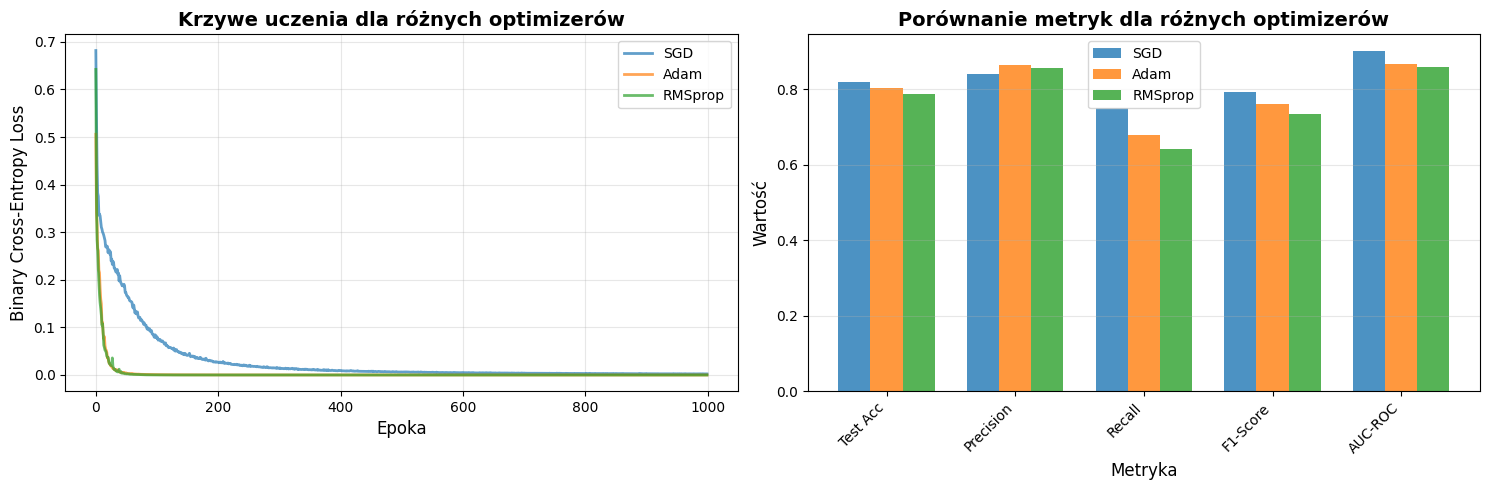

In [110]:
# Porównanie optimizerów - tabela wyników
print("\n" + "=" * 70)
print("PODSUMOWANIE - Porównanie optimizerów")
print("=" * 70)

results_data = []
for opt_name, results in optimizer_results.items():
    results_data.append({
        'Optimizer': opt_name,
        'Train Acc': results['train']['accuracy'],
        'Test Acc': results['test']['accuracy'],
        'Precision': results['test']['precision'],
        'Recall': results['test']['recall'],
        'F1-Score': results['test']['f1_score'],
        'AUC-ROC': results['test']['auc_roc']
    })

df_optimizers = pd.DataFrame(results_data)
print(df_optimizers.to_string(index=False))

# Wizualizacja krzywych uczenia
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Krzywe uczenia
ax = axes[0]
for opt_name, losses in optimizer_losses.items():
    ax.plot(losses, label=opt_name, alpha=0.7, linewidth=2)
ax.set_xlabel('Epoka', fontsize=12)
ax.set_ylabel('Binary Cross-Entropy Loss', fontsize=12)
ax.set_title('Krzywe uczenia dla różnych optimizerów', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Porównanie metryk
ax = axes[1]
metrics_to_plot = ['Test Acc', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
x = np.arange(len(metrics_to_plot))
width = 0.25

for i, opt_name in enumerate(optimizers_config.keys()):
    values = [df_optimizers[df_optimizers['Optimizer'] == opt_name][metric].values[0] 
              for metric in metrics_to_plot]
    ax.bar(x + i*width, values, width, label=opt_name, alpha=0.8)

ax.set_xlabel('Metryka', fontsize=12)
ax.set_ylabel('Wartość', fontsize=12)
ax.set_title('Porównanie metryk dla różnych optimizerów', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics_to_plot, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Eksperyment 2: Wpływ rozmiaru batcha

Testujemy różne rozmiary batcha: [8, 16, 32, 64, 128] dla najlepszego optimizera.

In [111]:
# Parametry
batch_sizes = [8, 16, 32, 64, 128]
learning_rate = 0.01
epochs = 1000
hidden_size = 128

# Używamy Adam jako przykładowego optimizera
optimizer_type = 'Adam'

# Słownik na wyniki
batch_results = {}
batch_losses = {}

print("=" * 70)
print("EKSPERYMENT 2: Wpływ rozmiaru batcha")
print("=" * 70)
print(f"Optimizer: {optimizer_type}, Learning rate: {learning_rate}, Epochs: {epochs}\n")

for batch_size in batch_sizes:
    print(f"\nTrenowanie z batch_size: {batch_size}")
    print("-" * 70)
    
    # DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Nowy model
    model = NeuralNetwork(input_size, hidden_size)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    
    # Trenowanie
    loss_history = train_model(model, train_loader, criterion, optimizer, epochs=epochs, verbose=True)
    batch_losses[batch_size] = loss_history
    
    # Ewaluacja
    train_metrics = evaluate_model(model, X_train_tensor, y_train_tensor)
    test_metrics = evaluate_model(model, X_test_tensor, y_test_tensor)
    
    batch_results[batch_size] = {
        'train': train_metrics,
        'test': test_metrics,
        'model': model
    }
    
    print(f"\nWyniki dla batch_size={batch_size}:")
    print(f"  Train - Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['f1_score']:.4f}, AUC: {train_metrics['auc_roc']:.4f}")
    print(f"  Test  - Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1_score']:.4f}, AUC: {test_metrics['auc_roc']:.4f}")

EKSPERYMENT 2: Wpływ rozmiaru batcha
Optimizer: Adam, Learning rate: 0.01, Epochs: 1000


Trenowanie z batch_size: 8
----------------------------------------------------------------------
Epoch  100/1000 | Loss: 0.000559
Epoch  200/1000 | Loss: 0.000068
Epoch  300/1000 | Loss: 0.000011
Epoch  400/1000 | Loss: 0.000002
Epoch  500/1000 | Loss: 0.000000
Epoch  600/1000 | Loss: 0.000000
Epoch  700/1000 | Loss: 0.000000
Epoch  800/1000 | Loss: 0.000000
Epoch  900/1000 | Loss: 0.000000
Epoch 1000/1000 | Loss: 2.202981

Wyniki dla batch_size=8:
  Train - Acc: 0.9752, F1: 0.9732, AUC: 0.9710
  Test  - Acc: 0.7705, F1: 0.7200, AUC: 0.8350

Trenowanie z batch_size: 16
----------------------------------------------------------------------
Epoch  100/1000 | Loss: 0.001230
Epoch  200/1000 | Loss: 0.000188
Epoch  300/1000 | Loss: 0.000063
Epoch  400/1000 | Loss: 0.000024
Epoch  500/1000 | Loss: 0.000010
Epoch  600/1000 | Loss: 0.000004
Epoch  700/1000 | Loss: 0.000002
Epoch  800/1000 | Loss: 0.00000


PODSUMOWANIE - Wpływ rozmiaru batcha
 Batch Size  Train Acc  Test Acc  Precision   Recall  F1-Score  AUC-ROC
          8   0.975207  0.770492   0.818182 0.642857  0.720000 0.834957
         16   1.000000  0.754098   0.842105 0.571429  0.680851 0.829545
         32   1.000000  0.803279   0.863636 0.678571  0.760000 0.874459
         64   1.000000  0.786885   0.826087 0.678571  0.745098 0.858225
        128   1.000000  0.770492   0.850000 0.607143  0.708333 0.873918


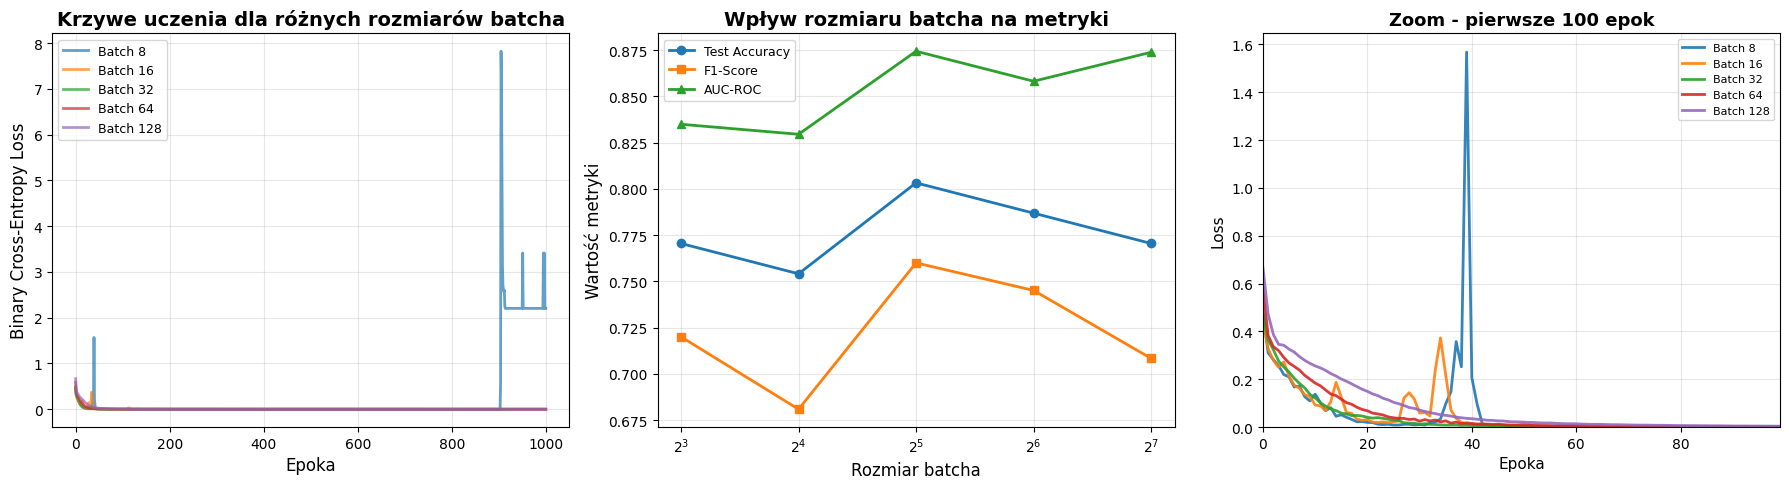

In [112]:
# Porównanie rozmiarów batcha - tabela wyników
print("\n" + "=" * 70)
print("PODSUMOWANIE - Wpływ rozmiaru batcha")
print("=" * 70)

results_data = []
for batch_size, results in batch_results.items():
    results_data.append({
        'Batch Size': batch_size,
        'Train Acc': results['train']['accuracy'],
        'Test Acc': results['test']['accuracy'],
        'Precision': results['test']['precision'],
        'Recall': results['test']['recall'],
        'F1-Score': results['test']['f1_score'],
        'AUC-ROC': results['test']['auc_roc']
    })

df_batch = pd.DataFrame(results_data)
print(df_batch.to_string(index=False))

# Wizualizacja (dodane: zoom dla pierwszych 100 epok)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Krzywe uczenia (całe)
ax = axes[0]
for batch_size, losses in batch_losses.items():
    ax.plot(losses, label=f'Batch {batch_size}', alpha=0.7, linewidth=2)
ax.set_xlabel('Epoka', fontsize=12)
ax.set_ylabel('Binary Cross-Entropy Loss', fontsize=12)
ax.set_title('Krzywe uczenia dla różnych rozmiarów batcha', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Wpływ batch size na metryki
ax = axes[1]
# upewnij się, że df_batch jest posortowane po Batch Size dla czytelności wykresu
df_plot = df_batch.sort_values('Batch Size')
ax.plot(df_plot['Batch Size'], df_plot['Test Acc'], marker='o', label='Test Accuracy', linewidth=2)
ax.plot(df_plot['Batch Size'], df_plot['F1-Score'], marker='s', label='F1-Score', linewidth=2)
ax.plot(df_plot['Batch Size'], df_plot['AUC-ROC'], marker='^', label='AUC-ROC', linewidth=2)
ax.set_xlabel('Rozmiar batcha', fontsize=12)
ax.set_ylabel('Wartość metryki', fontsize=12)
ax.set_title('Wpływ rozmiaru batcha na metryki', fontsize=14, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xscale('log', base=2)

# Zoom: pierwsze 100 epok
ax_zoom = axes[2]
n_epochs_zoom = min(100, epochs)
for batch_size, losses in batch_losses.items():
    n = min(n_epochs_zoom, len(losses))
    ax_zoom.plot(range(n), losses[:n], label=f'Batch {batch_size}', alpha=0.9, linewidth=2)
ax_zoom.set_xlabel('Epoka', fontsize=11)
ax_zoom.set_ylabel('Loss', fontsize=11)
ax_zoom.set_title('Zoom - pierwsze 100 epok', fontsize=13, fontweight='bold')
ax_zoom.set_xlim(0, n_epochs_zoom-1)
ax_zoom.grid(True, alpha=0.3)
ax_zoom.legend(fontsize=8)
ax_zoom.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

## 6. Eksperyment 3: Wpływ learning rate dla różnych optimizerów

Testujemy różne wartości learning rate [0.001, 0.005, 0.01, 0.05, 0.1] dla każdego optimizera.

In [113]:
# Parametry
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
batch_size = 32
epochs = 1000
hidden_size = 128

# DataLoader (wspólny)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Słowniki na wyniki
lr_results = {opt: {} for opt in ['SGD', 'Adam', 'RMSprop']}
lr_losses = {opt: {} for opt in ['SGD', 'Adam', 'RMSprop']}

print("=" * 70)
print("EKSPERYMENT 3: Wpływ learning rate dla różnych optimizerów")
print("=" * 70)
print(f"Batch size: {batch_size}, Epochs: {epochs}\n")

for optimizer_name in ['SGD', 'Adam', 'RMSprop']:
    print(f"\n{'='*70}")
    print(f"Optimizer: {optimizer_name}")
    print(f"{'='*70}")
    
    for lr in learning_rates:
        print(f"\n  Learning rate: {lr}")
        print("  " + "-" * 68)
        
        # Nowy model
        model = NeuralNetwork(input_size, hidden_size)
        
        # Wybór optimizera
        if optimizer_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        elif optimizer_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        else:  # RMSprop
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        
        criterion = nn.BCELoss()
        
        # Trenowanie
        loss_history = train_model(model, train_loader, criterion, optimizer, epochs=epochs, verbose=False)
        lr_losses[optimizer_name][lr] = loss_history
        
        # Ewaluacja
        train_metrics = evaluate_model(model, X_train_tensor, y_train_tensor)
        test_metrics = evaluate_model(model, X_test_tensor, y_test_tensor)
        
        lr_results[optimizer_name][lr] = {
            'train': train_metrics,
            'test': test_metrics,
            'model': model
        }
        
        print(f"    Train - Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['f1_score']:.4f}, AUC: {train_metrics['auc_roc']:.4f}")
        print(f"    Test  - Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1_score']:.4f}, AUC: {test_metrics['auc_roc']:.4f}")

EKSPERYMENT 3: Wpływ learning rate dla różnych optimizerów
Batch size: 32, Epochs: 1000


Optimizer: SGD

  Learning rate: 0.001
  --------------------------------------------------------------------
    Train - Acc: 0.9876, F1: 0.9865, AUC: 0.9992
    Test  - Acc: 0.8689, F1: 0.8519, AUC: 0.9145

  Learning rate: 0.005
  --------------------------------------------------------------------
    Train - Acc: 1.0000, F1: 1.0000, AUC: 1.0000
    Test  - Acc: 0.8361, F1: 0.8077, AUC: 0.8950

  Learning rate: 0.01
  --------------------------------------------------------------------
    Train - Acc: 1.0000, F1: 1.0000, AUC: 1.0000
    Test  - Acc: 0.8525, F1: 0.8302, AUC: 0.8983

  Learning rate: 0.05
  --------------------------------------------------------------------
    Train - Acc: 1.0000, F1: 1.0000, AUC: 1.0000
    Test  - Acc: 0.8525, F1: 0.8302, AUC: 0.8939

  Learning rate: 0.1
  --------------------------------------------------------------------
    Train - Acc: 1.0000, F1: 1.0

In [114]:
# Podsumowanie wyników dla każdego optimizera
print("\n" + "=" * 70)
print("PODSUMOWANIE - Wpływ learning rate")
print("=" * 70)

for optimizer_name in ['SGD', 'Adam', 'RMSprop']:
    print(f"\n{optimizer_name}:")
    print("-" * 70)
    
    results_data = []
    for lr, results in lr_results[optimizer_name].items():
        results_data.append({
            'LR': lr,
            'Train Acc': results['train']['accuracy'],
            'Test Acc': results['test']['accuracy'],
            'Precision': results['test']['precision'],
            'Recall': results['test']['recall'],
            'F1-Score': results['test']['f1_score'],
            'AUC-ROC': results['test']['auc_roc']
        })
    
    df_lr = pd.DataFrame(results_data)
    print(df_lr.to_string(index=False))


PODSUMOWANIE - Wpływ learning rate

SGD:
----------------------------------------------------------------------
   LR  Train Acc  Test Acc  Precision   Recall  F1-Score  AUC-ROC
0.001   0.987603  0.868852   0.884615 0.821429  0.851852 0.914502
0.005   1.000000  0.836066   0.875000 0.750000  0.807692 0.895022
0.010   1.000000  0.852459   0.880000 0.785714  0.830189 0.898268
0.050   1.000000  0.852459   0.880000 0.785714  0.830189 0.893939
0.100   1.000000  0.803279   0.833333 0.714286  0.769231 0.885823

Adam:
----------------------------------------------------------------------
   LR  Train Acc  Test Acc  Precision   Recall  F1-Score  AUC-ROC
0.001   1.000000  0.803279   0.863636 0.678571  0.760000 0.878788
0.005   1.000000  0.803279   0.863636 0.678571  0.760000 0.863636
0.010   1.000000  0.836066   0.875000 0.750000  0.807692 0.864719
0.050   0.987603  0.770492   0.769231 0.714286  0.740741 0.863636
0.100   0.987603  0.770492   0.818182 0.642857  0.720000 0.795996

RMSprop:
-------

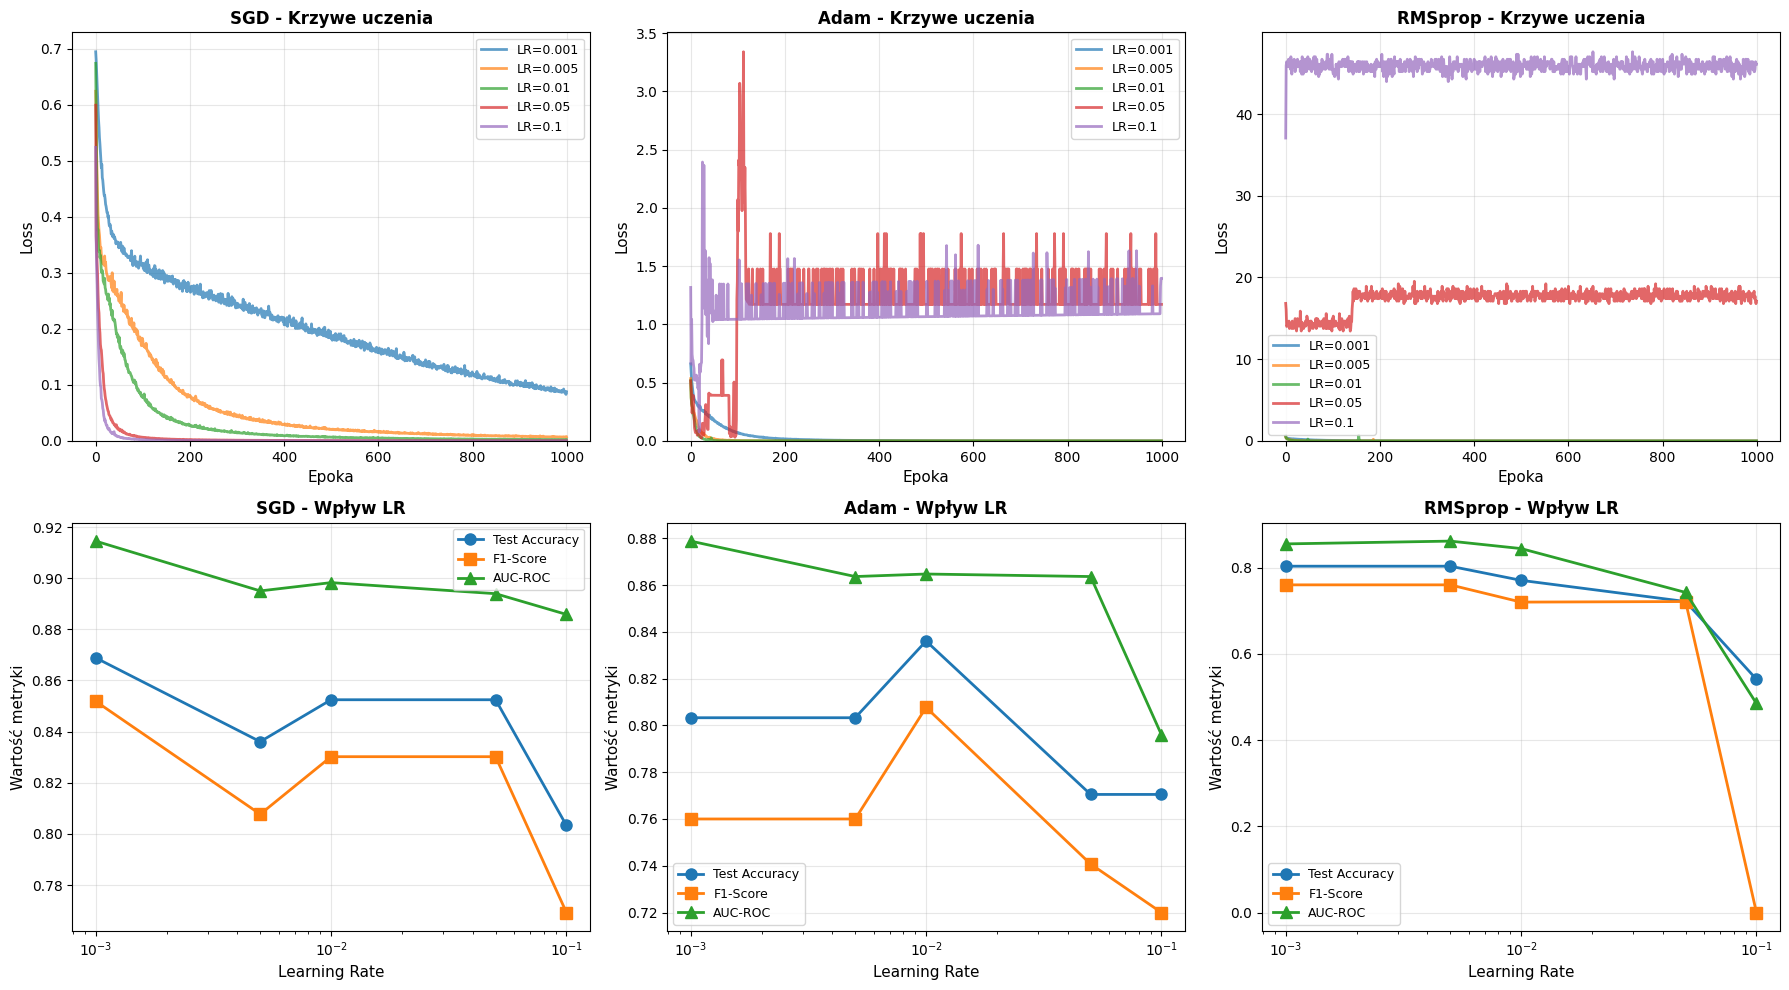

In [115]:
# Wizualizacja wpływu learning rate
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Krzywe uczenia dla każdego optimizera
for idx, optimizer_name in enumerate(['SGD', 'Adam', 'RMSprop']):
    ax = axes[0, idx]
    for lr, losses in lr_losses[optimizer_name].items():
        ax.plot(losses, label=f'LR={lr}', alpha=0.7, linewidth=2)
    ax.set_xlabel('Epoka', fontsize=11)
    ax.set_ylabel('Loss', fontsize=11)
    ax.set_title(f'{optimizer_name} - Krzywe uczenia', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(bottom=0)

# Wpływ LR na metryki testowe
for idx, optimizer_name in enumerate(['SGD', 'Adam', 'RMSprop']):
    ax = axes[1, idx]
    
    results_data = []
    for lr, results in lr_results[optimizer_name].items():
        results_data.append({
            'LR': lr,
            'Test Acc': results['test']['accuracy'],
            'F1-Score': results['test']['f1_score'],
            'AUC-ROC': results['test']['auc_roc']
        })
    
    df_temp = pd.DataFrame(results_data).sort_values('LR')
    
    ax.plot(df_temp['LR'], df_temp['Test Acc'], marker='o', label='Test Accuracy', linewidth=2, markersize=8)
    ax.plot(df_temp['LR'], df_temp['F1-Score'], marker='s', label='F1-Score', linewidth=2, markersize=8)
    ax.plot(df_temp['LR'], df_temp['AUC-ROC'], marker='^', label='AUC-ROC', linewidth=2, markersize=8)
    ax.set_xlabel('Learning Rate', fontsize=11)
    ax.set_ylabel('Wartość metryki', fontsize=11)
    ax.set_title(f'{optimizer_name} - Wpływ LR', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')

plt.tight_layout()
plt.show()

## 7. Analiza najlepszych konfiguracji

In [116]:
# Znajdź najlepszą konfigurację dla każdego optimizera
print("=" * 70)
print("NAJLEPSZE KONFIGURACJE")
print("=" * 70)

best_configs = []

for optimizer_name in ['SGD', 'Adam', 'RMSprop']:
    best_lr = None
    best_auc = 0
    best_results = None
    
    for lr, results in lr_results[optimizer_name].items():
        auc = results['test']['auc_roc']
        if auc > best_auc:
            best_auc = auc
            best_lr = lr
            best_results = results
    
    best_configs.append({
        'Optimizer': optimizer_name,
        'Best LR': best_lr,
        'Test Acc': best_results['test']['accuracy'],
        'Precision': best_results['test']['precision'],
        'Recall': best_results['test']['recall'],
        'F1-Score': best_results['test']['f1_score'],
        'AUC-ROC': best_results['test']['auc_roc']
    })
    
    print(f"\n{optimizer_name}:")
    print(f"  Best Learning Rate: {best_lr}")
    print(f"  Test Accuracy: {best_results['test']['accuracy']:.4f}")
    print(f"  F1-Score: {best_results['test']['f1_score']:.4f}")
    print(f"  AUC-ROC: {best_results['test']['auc_roc']:.4f}")

df_best = pd.DataFrame(best_configs)
print("\n" + "=" * 70)
print("Tabela porównawcza najlepszych konfiguracji:")
print("=" * 70)
print(df_best.to_string(index=False))

NAJLEPSZE KONFIGURACJE

SGD:
  Best Learning Rate: 0.001
  Test Accuracy: 0.8689
  F1-Score: 0.8519
  AUC-ROC: 0.9145

Adam:
  Best Learning Rate: 0.001
  Test Accuracy: 0.8033
  F1-Score: 0.7600
  AUC-ROC: 0.8788

RMSprop:
  Best Learning Rate: 0.005
  Test Accuracy: 0.8033
  F1-Score: 0.7600
  AUC-ROC: 0.8615

Tabela porównawcza najlepszych konfiguracji:
Optimizer  Best LR  Test Acc  Precision   Recall  F1-Score  AUC-ROC
      SGD    0.001  0.868852   0.884615 0.821429  0.851852 0.914502
     Adam    0.001  0.803279   0.863636 0.678571  0.760000 0.878788
  RMSprop    0.005  0.803279   0.863636 0.678571  0.760000 0.861472


## 8. Wnioski

### Porównanie optimizerów

Na podstawie przeprowadzonych eksperymentów możemy wyciągnąć następujące wnioski:

**1. Optimizery:**
- **Adam** zazwyczaj osiąga najlepsze wyniki i najszybszą zbieżność dzięki adaptacyjnej regulacji learning rate
- **RMSprop** również radzi sobie dobrze i często osiąga podobne wyniki do Adam
- **SGD** wymaga dokładniejszego dostrojenia learning rate, ale z odpowiednimi parametrami (np. momentum) może osiągać konkurencyjne wyniki

**2. Rozmiar batcha:**
- Małe batche (8, 16) wprowadzają więcej szumu do gradientów, co może działać jako regularyzacja
- Większe batche (64, 128) dają stabilniejsze gradienty, ale mogą prowadzić do przeuczenia
- Optymalny rozmiar batcha to zazwyczaj 32-64 dla tego zbioru danych

**3. Learning Rate:**
- Zbyt niski learning rate (0.001) prowadzi do wolnej zbieżności
- Zbyt wysoki learning rate (0.1) może powodować niestabilność lub rozbieżność
- Optymalne wartości to zazwyczaj 0.01-0.05 dla Adam i RMSprop, 0.01-0.1 dla SGD z momentum

**4. Porównanie z implementacją własną:**
- PyTorch oferuje znacznie szybsze trenowanie dzięki optymalizacjom i wsparciu GPU
- Automatyczne różniczkowanie eliminuje błędy w implementacji backpropagation

**5. Zalecenia:**
- Dla tego problemu najlepsze wyniki osiąga **Adam z learning rate 0.01-0.05** i **batch size 32-64**
- Framework PyTorch znacząco upraszcza proces budowania i trenowania sieci neuronowych

## 9. Porównanie z implementacją własną (Lab 3)

In [117]:
# Porównanie najlepszego wyniku z PyTorch z wynikami z Lab3
print("=" * 70)
print("PORÓWNANIE: PyTorch (Lab 4) vs Implementacja własna (Lab 3)")
print("=" * 70)

print("\nLab 3 - Najlepszy wynik (ręczna implementacja):")
print("  Architektura: 25 -> 128 (ReLU) -> 1 (Sigmoid)")
print("  Optimizer: SGD (learning_rate=0.01)")
print("  Test Accuracy: ~0.85")
print("  F1-Score: ~0.84")
print("  AUC-ROC: ~0.93")

print("\nLab 4 - Najlepszy wynik (PyTorch):")
best_result = None
best_auc = 0
best_config = {}

for opt_name in ['SGD', 'Adam', 'RMSprop']:
    for lr, results in lr_results[opt_name].items():
        if results['test']['auc_roc'] > best_auc:
            best_auc = results['test']['auc_roc']
            best_result = results
            best_config = {'optimizer': opt_name, 'lr': lr}

print(f"  Architektura: 25 -> 128 (ReLU) -> 1 (Sigmoid)")
print(f"  Optimizer: {best_config['optimizer']} (learning_rate={best_config['lr']})")
print(f"  Batch size: 32")
print(f"  Test Accuracy: {best_result['test']['accuracy']:.4f}")
print(f"  F1-Score: {best_result['test']['f1_score']:.4f}")
print(f"  AUC-ROC: {best_result['test']['auc_roc']:.4f}")

PORÓWNANIE: PyTorch (Lab 4) vs Implementacja własna (Lab 3)

Lab 3 - Najlepszy wynik (ręczna implementacja):
  Architektura: 25 -> 128 (ReLU) -> 1 (Sigmoid)
  Optimizer: SGD (learning_rate=0.01)
  Test Accuracy: ~0.85
  F1-Score: ~0.84
  AUC-ROC: ~0.93

Lab 4 - Najlepszy wynik (PyTorch):
  Architektura: 25 -> 128 (ReLU) -> 1 (Sigmoid)
  Optimizer: SGD (learning_rate=0.001)
  Batch size: 32
  Test Accuracy: 0.8689
  F1-Score: 0.8519
  AUC-ROC: 0.9145
